Load the data

In [115]:
# Hide warnings if there are any
import warnings
warnings.filterwarnings('ignore')
import ast

# Load in the r magic
%load_ext sql
%load_ext cython
%load_ext rpy2.ipython

# We need ggplot2%%
%R library(ggplot2)
%R library(magrittr)
%R library(gridExtra)

# Load in the pandas library
import pandas as pd
import numpy as np
from rpy2.robjects import pandas2ri, r
from textblob import TextBlob
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.regularizers import l2
from keras.optimizers import SGD
import re
import ast
import random

df = pd.read_csv('ted_main.csv')

pandas2ri.activate()

%R -i df

The sql extension is already loaded. To reload it, use:
  %reload_ext sql
The cython extension is already loaded. To reload it, use:
  %reload_ext cython
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


We define aggregate ratings as the sum of some descriptions and the difference of some others. These are considered positive: 

Funny, Courageous, Beautiful, Informative, Inspiring, Fascinating, Ingenious, Persuasive, Jaw-dropping

These are considered negative: 

Confusing, Unconvincing, Longwinded, Obnoxious, OK

In [79]:
df['ratings'] = df['ratings'].apply(lambda x: eval(str(x)))
df['aggregateRatings'] = df['ratings'].apply(lambda x: \
                                            x[0]['count']+ \
                                            x[1]['count']- \
                                            x[2]['count']+ \
                                            x[3]['count']- \
                                            x[4]['count']- \
                                            x[5]['count']+ \
                                            x[6]['count']+ \
                                            x[7]['count']+ \
                                            x[8]['count']+ \
                                            x[9]['count']+ \
                                            x[10]['count']+ \
                                            x[11]['count']- \
                                            x[12]['count']- \
                                            x[13]['count'])
ar = df['aggregateRatings']
%R -i ar

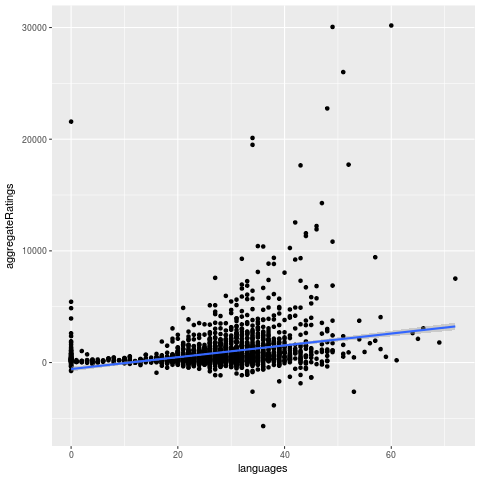

In [8]:
%%R
df$aggregateRatings <- ar
ggplot(aes(x=languages,y=aggregateRatings),data=df)+
    geom_point(stat="identity")+
    geom_smooth(method='lm')

Note that this graph is not on a log scale as some ratings are negative. Still, there is a correlation between languages and ratings - which doesn't seem immediately intuitive. Possibly this is really attributable to views and comments. 

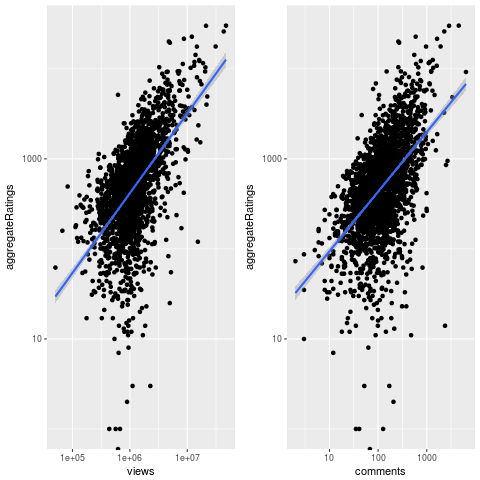

In [9]:
%%R
plot1 <- ggplot(aes(x=views,y=aggregateRatings),data=df)+
    geom_point(stat="identity")+
    scale_y_log10()+
    scale_x_log10()+
    geom_smooth(method='lm')
plot2 <- ggplot(aes(x=comments,y=aggregateRatings),data=df)+
    geom_point(stat="identity")+
    scale_y_log10()+
    scale_x_log10()+
    geom_smooth(method='lm')
grid.arrange(plot1,plot2,ncol=2)

Again, there is a general positive trend in both cases, with some outliers tending towards more negative ratings. We can conlude rather naturally that talks people like seem to be more viewed and commented on, and thus rated more highly. However, this also introduces a rating bias toward more highly-viewed talks. Thus, we define a new data column which is aggregate rating per view: 

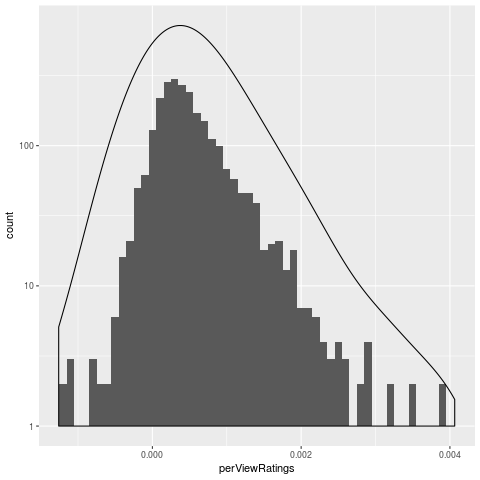

In [10]:
%%R
df$perViewRatings <- df$aggregateRatings/df$views
summary(df$perViewRatings)
ggplot(aes(x=perViewRatings),data=df)+
    geom_histogram(binwidth=0.0001)+
    geom_density(adjust=5)+
    scale_y_log10()+
    xlim(quantile(df$perViewRatings,0.001),quantile(df$perViewRatings,0.999))

TODO: figure out why this density curve looks weird
Distribution of per-view ratings. Note that most talks fall on the positive side - most ratings given are positive. Now let's try to break it down by speaker occupation: 

In [64]:
%%R
aggregate(df$perViewRatings,df$speaker_occupation,mean)
#ggplot(aes(y=ratings_by_occupation),data=))+
 #   geom_histogram(binwidth=0.0001)+
  #  geom_density(adjust=5)+
   # scale_y_log10()+
    #xlim(quantile(df$perViewRatings,0.001),quantile(df$perViewRatings,0.999))

#lol i give up on this one grouping is hard

Error in aggregate.data.frame(as.data.frame(x), ...) : 
  'by' must be a list


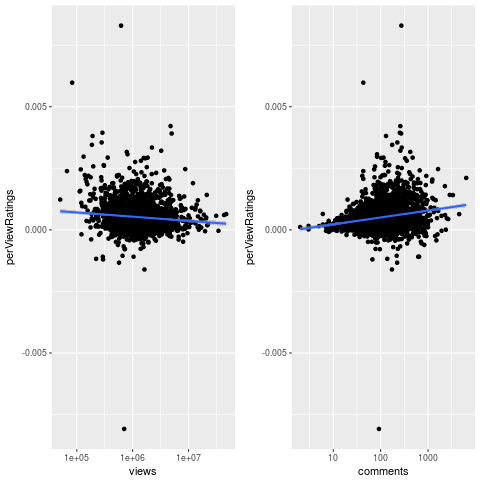

In [12]:
%%R
plot1 <- ggplot(aes(x=views,y=perViewRatings),data=df)+
    geom_point(stat="identity")+
    scale_x_log10()+
    geom_smooth(method='lm')
plot2 <- ggplot(aes(x=comments,y=perViewRatings),data=df)+
    geom_point(stat="identity")+
    scale_x_log10()+
    geom_smooth(method='lm')
grid.arrange(plot1,plot2,ncol=2)

This is more interesting. While more comments seem to indicate higher ratings per view, the opposite is true for number of views.

What about trying to predict ratings per view based on various factors? This is where machine learning comes in. First select relevant features:

In [80]:
df['perViewRatings'] = df['aggregateRatings']/df['views']
mldf = df[['num_speaker','duration','comments','languages','views']]

Currently, this just consists of numerical values which already exist in the TED talks data set. However, it leaves out a lot of factors, such as the title and description of the talk. We can analyze these with natural language processing. 

There are a few approaches that can be taken. One of the possibilities is to perform a sentiment analysis on the description (or possibly the title) and consider this a feature. We can do this with the TextBlob library:

In [81]:
mldf['descriptionSentiment'] = df['description'].apply(lambda x:TextBlob(re.sub(r'[^\x00-\x7f]',r'',x)).sentiment.polarity)
print(mldf['descriptionSentiment'].head())
print(df['description']).head()

0    0.291667
1   -0.115909
2   -0.081981
3    0.000000
4    0.000000
Name: descriptionSentiment, dtype: float64
0    Sir Ken Robinson makes an entertaining and pro...
1    With the same humor and humanity he exuded in ...
2    New York Times columnist David Pogue takes aim...
3    In an emotionally charged talk, MacArthur-winn...
4    You've never seen data presented like this. Wi...
Name: description, dtype: object


Another possibility is analyzing tags based on vector embeddings. These embeddings can then be updated and optimized with the neural network at the same time. However this is tricky to get right since different talks have different numbers of tags. ~~One approach to resolving this issue is to randomly select one or several tags. Each talk has several tags; Rounak Banik's analysis indicates that the most popular tags have hundreds of talks. Thus the more common tags should still be popular enough to generate a good prediction.~~

One approach to resolving this is to use a one-hot encoding: 

In [82]:
df['tags'] = df['tags'].apply(lambda x:eval(str(x)))
all_tags = {}
count = 0
for talk in df['tags']:
    for tag in talk:
        if not tag in all_tags:
            all_tags[tag] = count
            count = count+1
onehot = np.zeros((0,count))
for talk in df['tags']:
    temp = np.zeros((1,count))
    for tag in talk:
        temp[0,all_tags[tag]] = 1
    onehot = np.concatenate((onehot,temp),0)

Now we are ready to create the machine learning model. Our model will be a neural network, implemented in Keras using a TensorFlow backend. We first create the training and validation data sets, then we create the model.

In [102]:
mldf_np = mldf.as_matrix()
all_y = np.reshape(df['perViewRatings'].as_matrix(),(np.shape(all_y)[0],1))
all_x = np.concatenate((mldf_np,onehot),1)
combined = np.concatenate((all_x,all_y),1)
np.random.shuffle(combined)
combined = np.reshape(combined,(np.shape(combined)[0],np.shape(combined)[1],1))
data_size = np.shape(all_y)[0]
train_size = (int)(data_size*0.75)
feature_size = np.shape(all_x)[1]
x_train = combined[0:train_size,0:feature_size,:]
y_train = np.reshape(combined[0:train_size,feature_size,:],(-1,1,1))
x_val = combined[train_size:data_size,0:feature_size,:]
y_val = np.reshape(combined[train_size:data_size,feature_size,:],(-1,1,1))

In [127]:
model = Sequential()
model.add(Dense(64,activation=Activation('relu'),input_shape=(None,1),kernel_regularizer=l2(0.01)))
model.add(Dense(1,kernel_regularizer=l2(0.01)))
model.compile(loss='mean_squared_error',optimizer="adam")
history = model.fit(x=x_train,y=y_train,batch_size=64,epochs=10,validation_data=(x_val,y_val))

Train on 1912 samples, validate on 638 samples
Epoch 1/10
1912/1912 [==============================] - 0s - loss: 9508068.3714 - val_loss: 1804935.3726
Epoch 2/10
1912/1912 [==============================] - 0s - loss: 204729.5956 - val_loss: 57921.9315
Epoch 3/10
1912/1912 [==============================] - 0s - loss: 14420.9790 - val_loss: 212.7041
Epoch 4/10
1912/1912 [==============================] - 0s - loss: 290.1225 - val_loss: 143.7403
Epoch 5/10
1912/1912 [==============================] - 0s - loss: 45.5591 - val_loss: 5.9382
Epoch 6/10
1912/1912 [==============================] - 0s - loss: 8.8821 - val_loss: 0.0266
Epoch 7/10
1912/1912 [==============================] - 0s - loss: 0.5998 - val_loss: 0.3591
Epoch 8/10
1912/1912 [==============================] - 0s - loss: 0.1019 - val_loss: 0.0236
Epoch 9/10
1912/1912 [==============================] - 1s - loss: 0.0252 - val_loss: 0.0241
Epoch 10/10
1912/1912 [==============================] - 0s - loss: 0.0233 - val_los

From the steadily decreasing loss on both test and validation data sets, it's clear that this neural network works very well. We can graph the losses:  

In [130]:
loss = history.history['loss']
val_loss = history.history['val_loss']
%R -i loss
%R -i val_loss

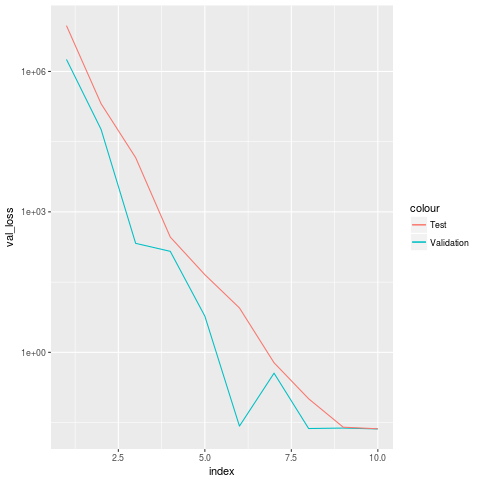

In [143]:
%%R
losses <- data.frame(loss=loss,val_loss=val_loss,index = 1:10)
ggplot(aes(index),data=losses) +
    geom_line(aes(y=val_loss,color="Validation")) +
    geom_line(aes(y=loss,color="Test")) +
    scale_y_log10()

While this neural network works well, it is possibly difficult to interpret due to the hidden layer. Thus, we also train a simpler version, with no hidden layer and linear activation. 

In [154]:
model = Sequential()
model.add(Dense(1,input_shape=(feature_size,1),kernel_regularizer=l2(0.01)))
model.compile(loss='mean_squared_error',optimizer="adam")
history = model.fit(x=x_train,y=y_train,batch_size=64,epochs=100,validation_data=(x_val,y_val),verbose=0)

ValueError: Error when checking target: expected dense_73 to have shape (None, 422, 1) but got array with shape (1912, 1, 1)

The output is omitted due to length, but we can graph the loss for this network as well. 

In [147]:
loss = history.history['loss']
val_loss = history.history['val_loss']
%R -i loss
%R -i val_loss

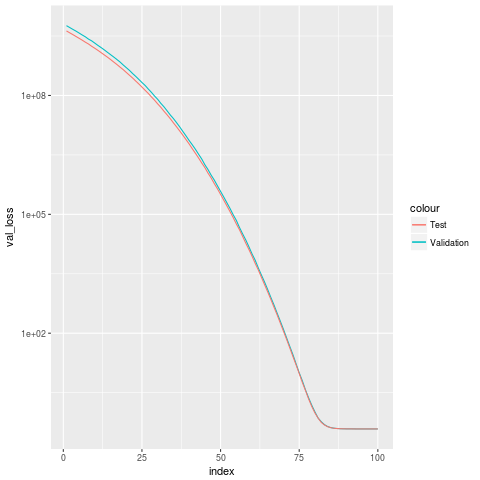

In [149]:
%%R
losses <- data.frame(loss=loss,val_loss=val_loss,index = 1:100)
ggplot(aes(index),data=losses) +
    geom_line(aes(y=val_loss,color="Validation")) +
    geom_line(aes(y=loss,color="Test")) +
    scale_y_log10()

This neural network achieves a similar accuracy but takes more epochs to train. However, it has the benefit of being easier to understand. As this neural network has linear activation with no hidden layers, its weights can be interpreted as directly affecting the final rating per view. A positive weight would indicate some correlation between that feature and rating per view, and vice versa.

In [151]:
for layer in model.layers:
    print(layer.get_weights()) 

[array([[  1.31199954e-07]], dtype=float32), array([-0.61935592], dtype=float32)]
